In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from keras.layers import Dense, Input, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import pandas as pd
import math
import seaborn as sns

2022-12-09 18:08:57.056508: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 18:08:57.456151: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-09 18:08:57.466680: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-09 18:08:57.466712: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
train_df = pd.read_csv('train_1Dx.csv',nrows=50000)
test_df = pd.read_csv('test_1Dx.csv',nrows=50000)

In [3]:
X_train = train_df.drop(columns=['x-midplane','cotAlpha']).values
X_test = test_df.drop(columns=['x-midplane','cotAlpha']).values

y_train = train_df['x-midplane'].values
y_test = test_df['x-midplane'].values

In [4]:
# scale so that it is between 0 and 1
def scale(X):
    width = np.max(X) - np.min(X)
    return ( X-np.min(X) ) / width

In [5]:
X_train = scale(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scale(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [6]:
def softplus_sigma(param):
    return 0.01+tf.math.softplus(param)

def custom_loss_gaussian(y, p):
    
    maxval = 1e9
    minval = 1e-9
    pi = 3.14159265359
    
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma = softplus_sigma(tf.gather(params=p, indices=[1], axis=1))
        
    likelihood = 1.0/tf.math.sqrt(2*pi)/sigma*tf.math.exp(-1*(y-mu)*(y-mu)/(2*sigma*sigma))
    likelihood = tf.clip_by_value(likelihood,minval,maxval)
    
    NLL = -1*tf.math.log(likelihood)
    
    return tf.keras.backend.sum(NLL,axis=1)

def custom_loss_double_gaussian(y, p):
    
    maxval = 1e9
    minval = 1e-9
    pi = 3.14159265359
    
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma1 = softplus_sigma(tf.gather(params=p, indices=[1], axis=1))
    sigma2 = softplus_sigma(tf.gather(params=p, indices=[2], axis=1))
    A = 0.99 + softplus_sigma(tf.gather(params=p, indices=[3], axis=1))
    
    norm1 = tf.math.sqrt(2*pi)*sigma1
    norm2 = tf.math.sqrt(2*pi)*sigma2
    
    normtot = norm1 + A*norm2
        
    term1 = tf.math.exp(-0.5*(y-mu)*(y-mu)/(sigma1*sigma1))
    term2 = tf.math.exp(-0.5*(y-mu)*(y-mu)/(sigma2*sigma2))
    
    likelihood = (term1 + A*term2)/normtot
    likelihood = tf.math.multiply_no_nan(likelihood,tf.cast(mu>0,tf.float32)*tf.cast(A>0,tf.float32)*tf.cast(sigma1>0,tf.float32)*tf.cast(sigma2>0,tf.float32))
    likelihood = tf.clip_by_value(likelihood,minval,1)
    
    NLL = -1*tf.math.log(likelihood)
    
    return tf.keras.backend.sum(NLL,axis=1)

In [7]:
def CreateModel(shape):
    x = x_in = Input(shape)
    x = Dense(64, name="dense1")(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(2, name="dense2")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateModel(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.0025),
              loss=custom_loss_gaussian)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense1 (Dense)              (None, 64)                1408      
                                                                 
 relu1 (Activation)          (None, 64)                0         
                                                                 
 dense2 (Dense)              (None, 2)                 130       
                                                                 
Total params: 1,538
Trainable params: 1,538
Non-trainable params: 0
_________________________________________________________________


2022-12-09 18:09:14.286996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-09 18:09:14.292657: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-09 18:09:14.292707: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-jennetd): /proc/driver/nvidia/version does not exist
2022-12-09 18:09:14.293435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
es = EarlyStopping(patience=10,
                  restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=500, 
                    batch_size=64,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/500
625/625 [==============================] - 3s 3ms/step - loss: 8.2296 - val_loss: 5.2380
Epoch 2/500
625/625 [==============================] - 1s 2ms/step - loss: 5.1930 - val_loss: 5.1637
Epoch 3/500
625/625 [==============================] - 1s 2ms/step - loss: 5.0431 - val_loss: 4.8958
Epoch 4/500
625/625 [==============================] - 1s 2ms/step - loss: 4.6726 - val_loss: 4.5244
Epoch 5/500
625/625 [==============================] - 1s 2ms/step - loss: 4.3942 - val_loss: 4.3488
Epoch 6/500
625/625 [==============================] - 1s 2ms/step - loss: 4.2496 - val_loss: 4.2147
Epoch 7/500
625/625 [==============================] - 1s 2ms/step - loss: 4.1184 - val_loss: 4.0942
Epoch 8/500
625/625 [==============================] - 1s 2ms/step - loss: 4.0083 - val_loss: 3.9975
Epoch 9/500
625/625 [==============================] - 1s 2ms/step - loss: 3.9262 - val_loss: 3.9280
Epoch 10/500
625/625 [==============================] - 1s 2ms/step - loss: 3.8675 - val_lo

/tmp/ipykernel_229633/3321773974.py:10: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


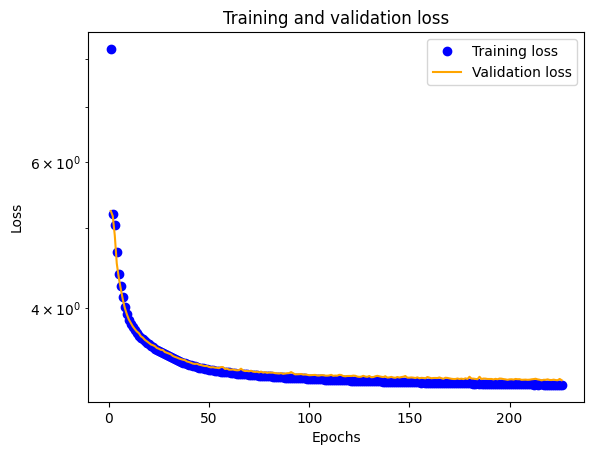

In [9]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()
plt.show()

In [10]:
model.save('models_1Dx_gauss.keras')

In [11]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['mu','sigma'])
df['sigma'] = softplus_sigma(df['sigma'])
df['xtrue'] = y_test
df.to_csv("test_1DxGauss.csv",header=False,index=False)

1563/1563 [==============================] - 2s 1ms/step


In [12]:
# Pixel boundaries
bounds = [-75,-25,25,75]

(0.0, 1219.05)

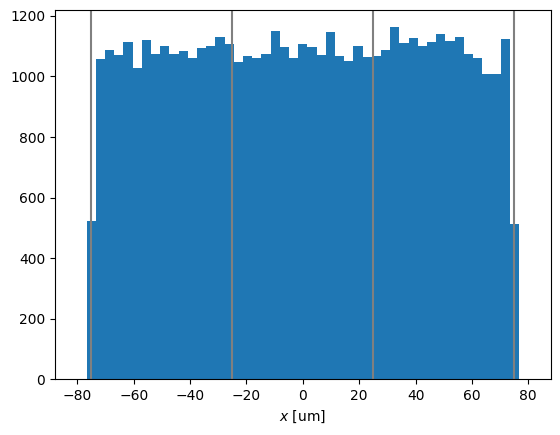

In [13]:
plt.hist(df['xtrue'],bins=np.linspace(-80,80,50))
plt.xlabel(r'$x$ [um]')

ylim=plt.ylim()
for b in bounds:
    plt.plot([b,b],ylim,color='gray')
plt.ylim(ylim)

-0.19064791606510062 7.308218107239704


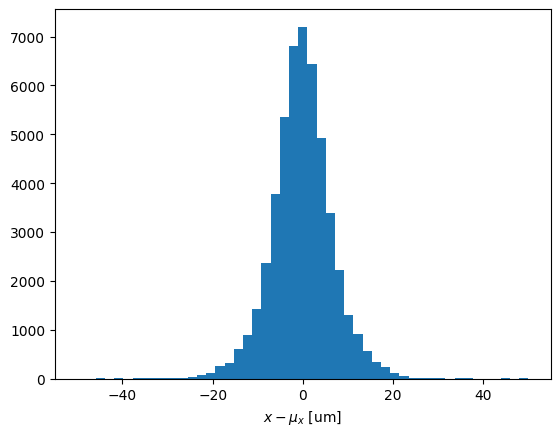

In [14]:
# Residuals
residuals = df['xtrue'] - df['mu']
print(np.mean(residuals),np.std(residuals))

plt.hist(residuals,bins=np.linspace(-50,50,50))
plt.xlabel(r'$x-\mu_x$ [um]')
plt.show()

6.206565 2.36978


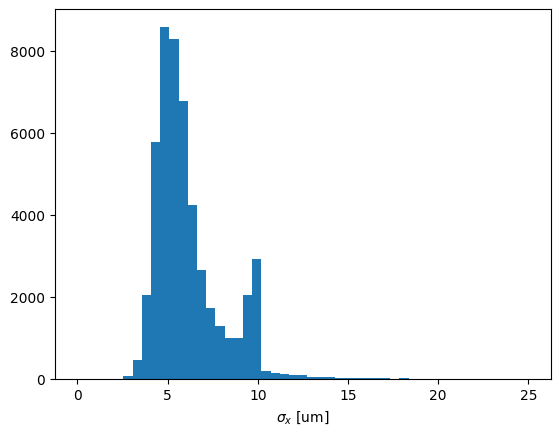

In [15]:
# Uncertainty
uncertainty= df['sigma']
print(np.mean(uncertainty),np.std(uncertainty))

plt.hist(uncertainty,bins=np.linspace(0,25,50));
plt.xlabel(r'$\sigma_x$ [um]')
plt.show()

(-5.499576441637101, 5.613936464103293)

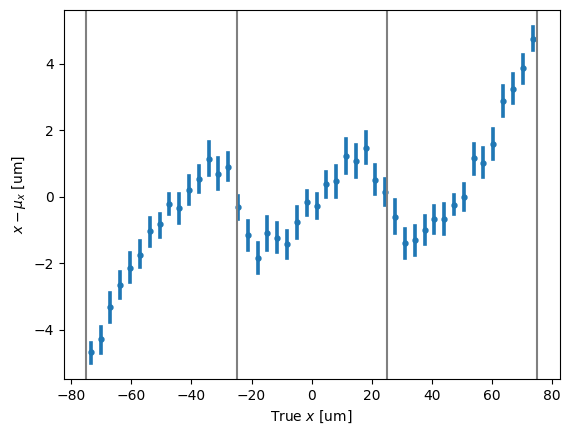

In [16]:
# Residuals vs true x

x = sns.regplot(x=df['xtrue'], y=df['xtrue']-df['mu'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')

ylim=plt.ylim()
for b in bounds:
    plt.plot([b,b],ylim,color='gray')
plt.ylim(ylim)

(4.9962825119495395, 7.090526908636093)

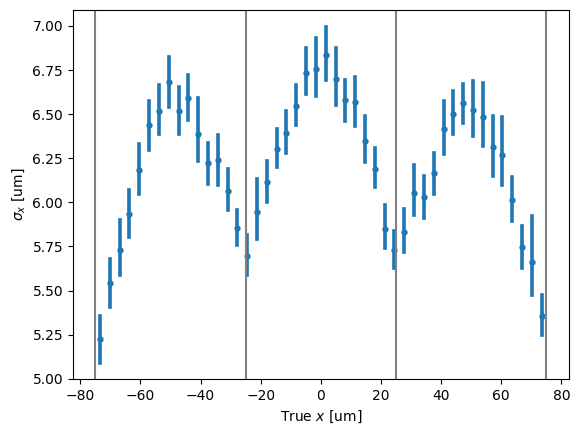

In [17]:
# Uncertainty vs true x
x = sns.regplot(x=df['xtrue'], y=df['sigma'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$\sigma_x$ [um]')

ylim=plt.ylim()
for b in bounds:
    plt.plot([b,b],ylim,color='gray')
plt.ylim(ylim)

-0.032781535683475305 1.0855411512713602


(0.1, 100000.0)

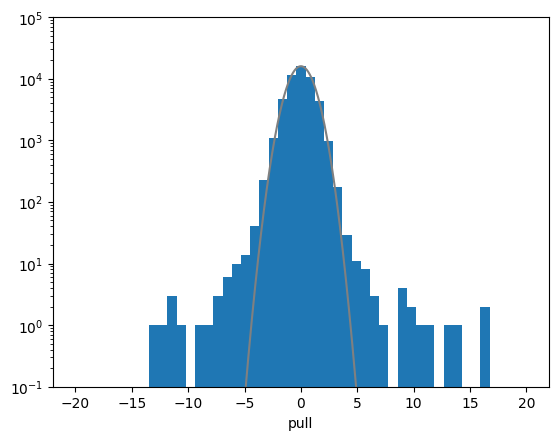

In [18]:
# Pulls
df['pulls'] = residuals/df['sigma']
print(np.mean(df['pulls']),np.std(df['pulls']))

plt.hist(df['pulls'],bins=np.linspace(-20,20,50));
plt.xlabel('pull')

x_axis = np.arange(-20, 20, 0.01)
width = 40/50.
plt.plot(x_axis, len(df)*norm.pdf(x_axis, 0, 1)*width,color='gray')
plt.yscale('log')

plt.ylim(0.1,1e5)